In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from sklearn.linear_model import LinearRegression

import scipy.stats as st
import statsmodels as sm
import scipy.optimize as opt
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [8]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [9]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [12]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [13]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

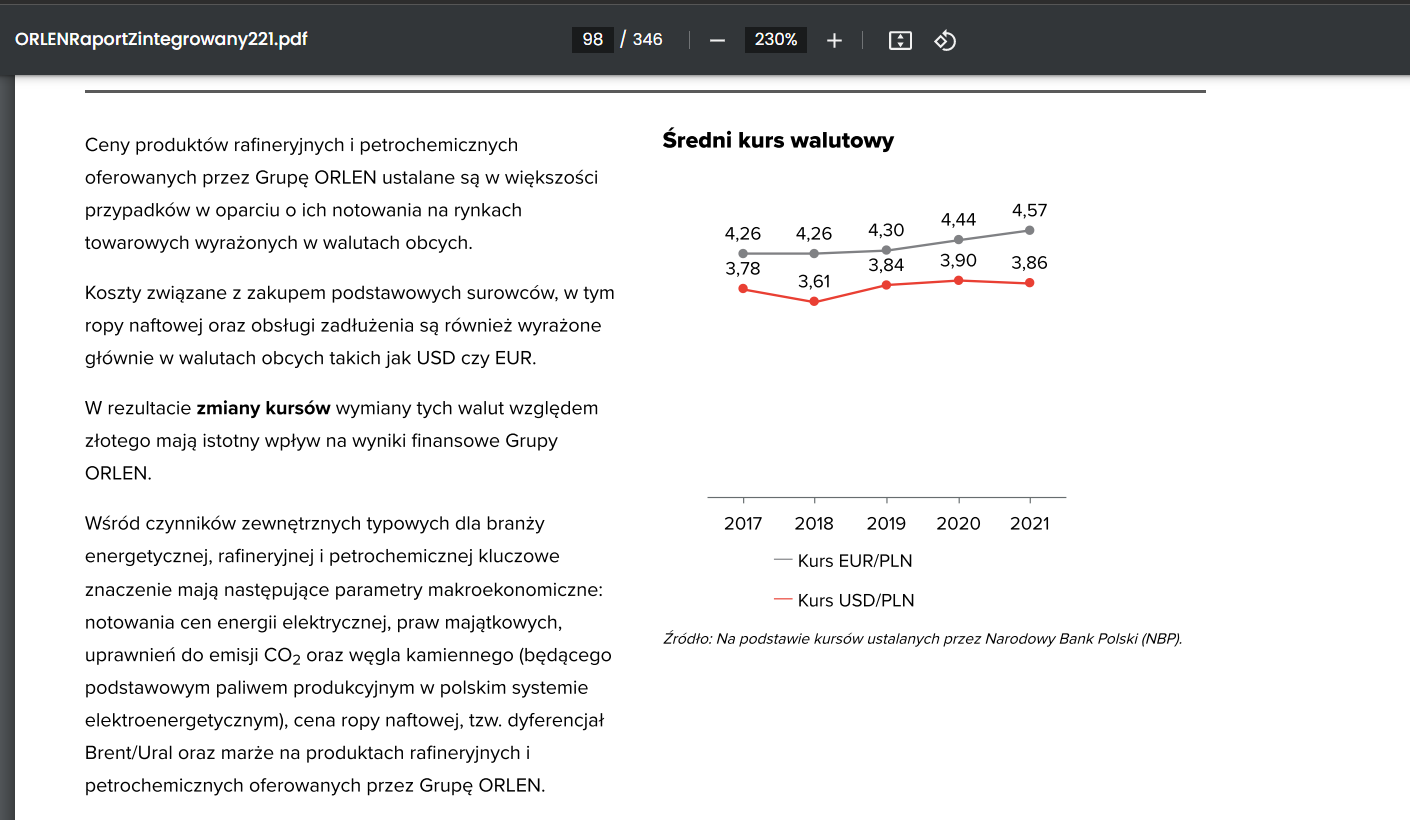

# Za zmienną ryzyka systemowego przyjmujemy kurs USD/PLN

In [14]:
usdpln_csv = pd.read_csv("usdpln.csv")
usdpln = pd.DataFrame()
usdpln["Data"] = usdpln_csv["Data"]
usdpln["Kurs USD/PLN"] = usdpln_csv["Zamkniecie"]

In [15]:
usdpln = usdpln.astype({"Data": "datetime64[ns]"})

In [16]:
df = gaz.merge(ropa, on="Data", how="inner").dropna()
df = df.sort_values(['Data'], ascending=[True])
df

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel]
3872,2007-07-30,6.4990,75.7400
3871,2007-07-31,6.1910,77.0500
3870,2007-08-01,6.3520,75.3500
3869,2007-08-02,6.1060,75.7600
3868,2007-08-03,6.0900,74.7500
...,...,...,...
4,2023-04-03,2.0970,84.9300
3,2023-04-04,2.1060,84.9400
2,2023-04-05,2.1550,84.9900
1,2023-04-10,2.1720,84.1800


In [17]:
df2 = df.merge(usdpln, on="Data", how="inner").dropna()
df2

,Data,Cena gazu [USD/Million Btu],Cena ropy [USD/Barrel],Kurs USD/PLN
0,2007-07-30,6.4990,75.7400,2.7706
1,2007-07-31,6.1910,77.0500,2.7667
2,2007-08-01,6.3520,75.3500,2.7751
3,2007-08-02,6.1060,75.7600,2.7676
4,2007-08-03,6.0900,74.7500,2.7486
...,...,...,...,...
3847,2023-04-03,2.0970,84.9300,4.2868
3848,2023-04-04,2.1060,84.9400,4.2706
3849,2023-04-05,2.1550,84.9900,4.2968
3850,2023-04-10,2.1720,84.1800,4.3157


# Ceny od 2017

In [18]:
mask = df2["Data"] > '2017-01-01'
df_merge = df2.loc[mask]
y_gaz = df_merge['Cena gazu [USD/Million Btu]']
y_ropa = df_merge['Cena ropy [USD/Barrel]']
y_usdpln = df_merge['Kurs USD/PLN']

In [19]:
df_final = pd.DataFrame()
df_final['Data'] = df_merge['Data']
df_final['przyrosty_log_gaz'] = np.log(y_gaz).diff()
df_final['przyrosty_log_ropa'] = np.log(y_ropa).diff()
df_final['przyrosty_log_usdpln'] = np.log(y_usdpln).diff()
df_final = df_final.dropna()

In [20]:
df_final = df_final.reset_index(drop=True)
df_final.head()

,Data,przyrosty_log_gaz,przyrosty_log_ropa,przyrosty_log_usdpln
0,2017-01-04,-0.0182,0.0177,-0.0117
1,2017-01-05,0.0018,0.0076,-0.0118
2,2017-01-06,0.0037,0.0037,0.0045
3,2017-01-09,-0.0570,-0.0386,0.0009
4,2017-01-10,0.0549,-0.0239,0.0006


## Wizualizacja danych

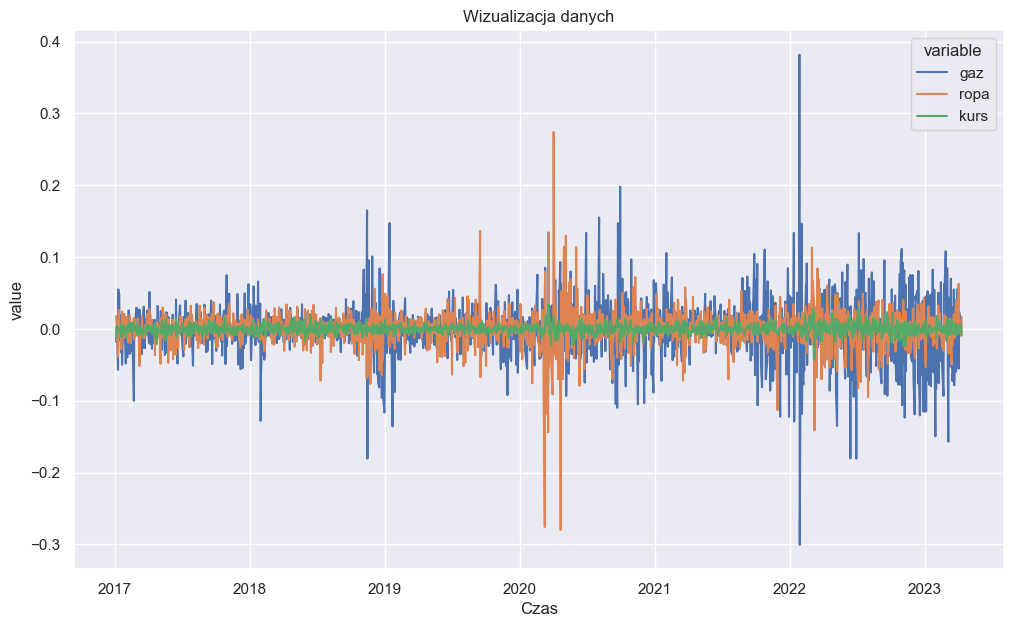

In [21]:
data_preproc = pd.DataFrame({
    'Data': df_final['Data'], 
    'gaz': df_final['przyrosty_log_gaz'],
    'ropa': df_final['przyrosty_log_ropa'],
    'kurs': df_final['przyrosty_log_usdpln']})

sns.lineplot(x='Data', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Data']))
plt.title('Wizualizacja danych')
plt.xlabel('Czas')
plt.show()

## Macierz korelacji

C:\Users\kinga\AppData\Local\Temp\ipykernel_15076\3745121201.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_final.corr()


<Axes: >

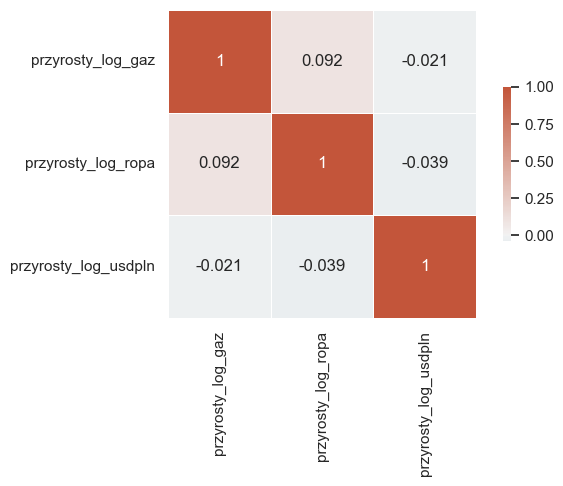

In [22]:
corr = df_final.corr()

f, ax = plt.subplots(figsize=(7, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, 
            cmap=cmap,
            annot=True,
            center=0,
            vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Przesunięcie wartości indeksu w czasie o 1 dzień
czyli jak wczorajsza cena kursu USD/PLN wpływa na dzisiejsze ceny ropy i gazu

In [23]:
k = 1

df_moved = pd.DataFrame()
df_moved['przyrosty_log_gaz'] = df_final['przyrosty_log_gaz'][k:]
df_moved['przyrosty_log_ropa'] = df_final['przyrosty_log_ropa'][k:]
df_moved['przyrosty_log_usdpln'] = df_final['przyrosty_log_usdpln'][:-k]

<Axes: >

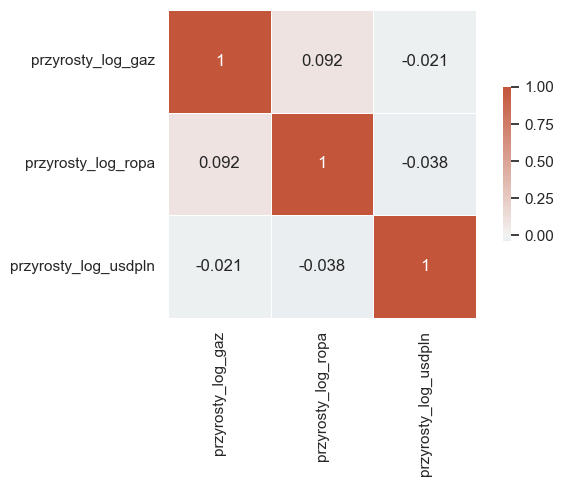

In [24]:
corr2 = df_moved.corr()

f, ax = plt.subplots(figsize=(7, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr2, 
            cmap=cmap,
            annot=True,
            center=0,
            vmax=1,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})

### Wniosek:
Zwiększanie różnicy w dniach daje coraz słabszą korelację

## Model jednowskaźnikowy

In [25]:
def jednowskaznikowy(R, Rs):
    lr = LinearRegression()

    lr.fit(np.expand_dims(Rs, axis=1), np.expand_dims(R, axis=1))

    beta, alpha= lr.coef_[0, 0], lr.intercept_[0]
    determinacja = beta **2 * np.var(Rs) / np.var(R)
    war_res = np.sum((R - alpha - beta * Rs) ** 2) / ( len(R) -1)
    
    nazwy = ['alpha_i', 'beta_i', 'Współczynnik determinacji', 'Wariancja residuów']
    wartości = [alpha, beta, determinacja, war_res]
    
    plt.scatter(Rs, R, color="#13C6EB")
    plt.plot([min(Rs), max(Rs)], [beta * min(Rs) + alpha, beta * max(Rs) + alpha], color="#F43D64")
    
    return pd.DataFrame({'Parametr':nazwy, 'Wartość':wartości})

,Parametr,Wartość
0,alpha_i,-0.0003
1,beta_i,-0.1246
2,Współczynnik determinacji,0.0004
3,Wariancja residuów,0.0016


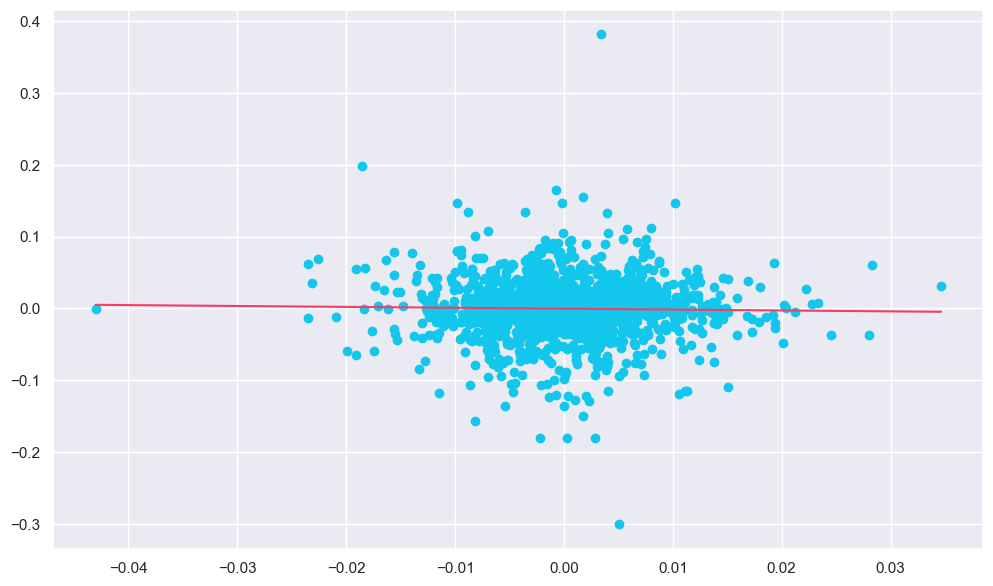

In [26]:
lr_gaz = jednowskaznikowy(df_final['przyrosty_log_gaz'], df_final['przyrosty_log_usdpln'])
lr_gaz

,Parametr,Wartość
0,alpha_i,0.0003
1,beta_i,-0.1589
2,Współczynnik determinacji,0.0015
3,Wariancja residuów,0.0007


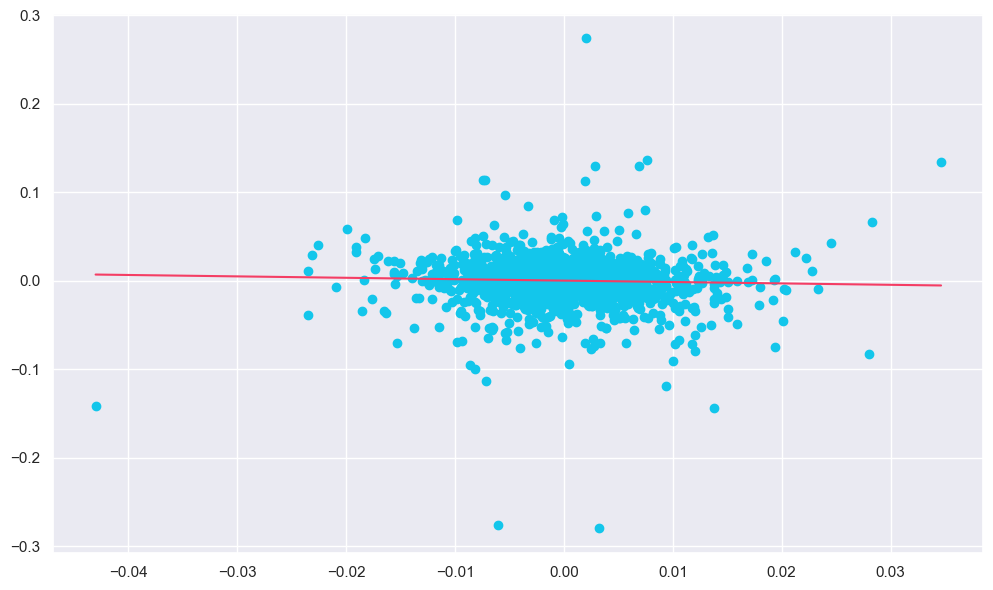

In [27]:
lr_ropa = jednowskaznikowy(df_final['przyrosty_log_ropa'], df_final['przyrosty_log_usdpln'])
lr_ropa

### Estymacja parametrów modelu

In [28]:
alpha_gaz = lr_gaz.iloc[0, 1]
beta_gaz = lr_gaz.iloc[1, 1]
alpha_ropa = lr_ropa.iloc[0, 1]
beta_ropa = lr_ropa.iloc[1, 1]

nazwy = ['alpha_gaz', 'beta_gaz', 'alpha_ropa', 'beta_ropa']
wartości = [alpha_gaz, beta_gaz, alpha_ropa, beta_ropa]
df_lr_coef = pd.DataFrame({'Parametr':nazwy, 'Wartość':wartości})
df_lr_coef

,Parametr,Wartość
0,alpha_gaz,-0.0003
1,beta_gaz,-0.1246
2,alpha_ropa,0.0003
3,beta_ropa,-0.1589


Wrażliwość - miara oczekiwanej zmiany $R_i$ przy zmianie $R_s$ = $\beta_i$

### Podstawienie do równania

In [29]:
# gaz
residua_gaz =  df_final['przyrosty_log_gaz'] - alpha_gaz - beta_gaz * df_final['przyrosty_log_usdpln']
a_gaz = alpha_gaz + residua_gaz

# ropa
residua_ropa =  df_final['przyrosty_log_ropa'] - alpha_ropa - beta_ropa * df_final['przyrosty_log_usdpln']
a_ropa = alpha_ropa + residua_ropa

# Założenia modelu
### - Ryzyko systemowe i specyficzne sa nieskorelowane

In [30]:
st.pearsonr(df_final['przyrosty_log_usdpln'], residua_gaz)

PearsonRResult(statistic=-3.469446951953614e-18, pvalue=0.9999999999999981)

In [31]:
(residua_gaz*(df_final['przyrosty_log_usdpln'] - df_final['przyrosty_log_usdpln'].mean())).mean()

5.545791163608719e-22

Nieskorelowane - p-wartość > 0.05 - nie odrzucam hipotezy o nieskorelowaniu

In [32]:
st.pearsonr(df_final['przyrosty_log_usdpln'], residua_ropa)

PearsonRResult(statistic=-2.688821387764051e-17, pvalue=0.9999999999999981)

In [33]:
(residua_ropa*(df_final['przyrosty_log_usdpln'] - df_final['przyrosty_log_usdpln'].mean())).mean()

-5.268501605428282e-21

Nieskorelowane

### Residua w modelu są nieskorelowane

In [37]:
st.pearsonr(residua_gaz, residua_ropa)

PearsonRResult(statistic=0.09091376855197998, pvalue=0.0003182302248097896)

są skorelowane

### Statystyki zmiennych ryzyka - średnia, odchylenie, korelacja

In [38]:
def mean_std_corr():
    
    nazwy = ['Średnia przyrostów gazu',
             'Średnia przyrostów ropy',
             'Odchylenie std przyrostów gazu',
             'Odchylenie std przyrostów ropy',
             'Współczynnik korelacji']
    
    wartosci = [alpha_gaz + beta_gaz*df_final['przyrosty_log_usdpln'].mean(),
                alpha_ropa + beta_ropa*df_final['przyrosty_log_usdpln'].mean(),
                np.var(residua_gaz) + beta_gaz**2 * np.var(df_final['przyrosty_log_usdpln']),
                np.var(residua_ropa) + beta_ropa**2 * np.var(df_final['przyrosty_log_usdpln']),
                beta_gaz*beta_ropa*np.var(df_final['przyrosty_log_usdpln'])]
    
    return pd.DataFrame({'Parametr':nazwy, 'Wartość': wartosci})

In [39]:
mean_std_corr()

,Parametr,Wartość
0,Średnia przyrostów gazu,-0.0003
1,Średnia przyrostów ropy,0.0003
2,Odchylenie std przyrostów gazu,0.0016
3,Odchylenie std przyrostów ropy,0.0007
4,Współczynnik korelacji,0.0000


# Kontrukcja portfeli z różnymi wagami dla modelu jednowskaźnikowego

In [40]:
space = np.linspace(0, 1, 100)
wagi = list(zip(space.round(decimals=2), (1-space).round(decimals=2)))
usd_przyrosty = df_final['przyrosty_log_usdpln']

In [41]:
portfele_residua = pd.DataFrame(index=["waga gaz", "waga ropa", "stopa zwrotu", "ryzyko"])

for waga_gaz, waga_ropa, in wagi:
    temp_portfel_residua = \
        waga_gaz*(a_gaz + usd_przyrosty * beta_gaz) + \
        waga_ropa*(a_ropa + usd_przyrosty* beta_ropa)
    
    portfele_residua[f"skóra: {waga_gaz}\nguma: {waga_ropa}"] = \
        [waga_gaz, 
         waga_ropa, 
         np.mean(temp_portfel_residua), 
         np.std(temp_portfel_residua, ddof=1)]
    

portfele_residua.head()

,skóra: 0.0\nguma: 1.0,skóra: 0.01\nguma: 0.99,skóra: 0.02\nguma: 0.98,skóra: 0.03\nguma: 0.97,skóra: 0.04\nguma: 0.96,skóra: 0.05\nguma: 0.95,skóra: 0.06\nguma: 0.94,skóra: 0.07\nguma: 0.93,skóra: 0.08\nguma: 0.92,skóra: 0.09\nguma: 0.91,...,skóra: 0.91\nguma: 0.09,skóra: 0.92\nguma: 0.08,skóra: 0.93\nguma: 0.07,skóra: 0.94\nguma: 0.06,skóra: 0.95\nguma: 0.05,skóra: 0.96\nguma: 0.04,skóra: 0.97\nguma: 0.03,skóra: 0.98\nguma: 0.02,skóra: 0.99\nguma: 0.01,skóra: 1.0\nguma: 0.0
waga gaz,0.0000,0.0100,0.0200,0.0300,0.0400,0.0500,0.0600,0.0700,0.0800,0.0900,...,0.9100,0.9200,0.9300,0.9400,0.9500,0.9600,0.9700,0.9800,0.9900,1.0000
waga ropa,1.0000,0.9900,0.9800,0.9700,0.9600,0.9500,0.9400,0.9300,0.9200,0.9100,...,0.0900,0.0800,0.0700,0.0600,0.0500,0.0400,0.0300,0.0200,0.0100,0.0000
stopa zwrotu,0.0003,0.0003,0.0003,0.0003,0.0003,0.0003,0.0002,0.0002,0.0002,0.0002,...,-0.0002,-0.0002,-0.0002,-0.0002,-0.0002,-0.0002,-0.0003,-0.0003,-0.0003,-0.0003
ryzyko,0.0271,0.0269,0.0266,0.0264,0.0262,0.0260,0.0258,0.0256,0.0254,0.0252,...,0.0369,0.0373,0.0377,0.0380,0.0384,0.0388,0.0391,0.0395,0.0399,0.0402


Text(0.5, 1.0, 'Portfele z różnymi wagami dla modelu jednowskaźnikowego')

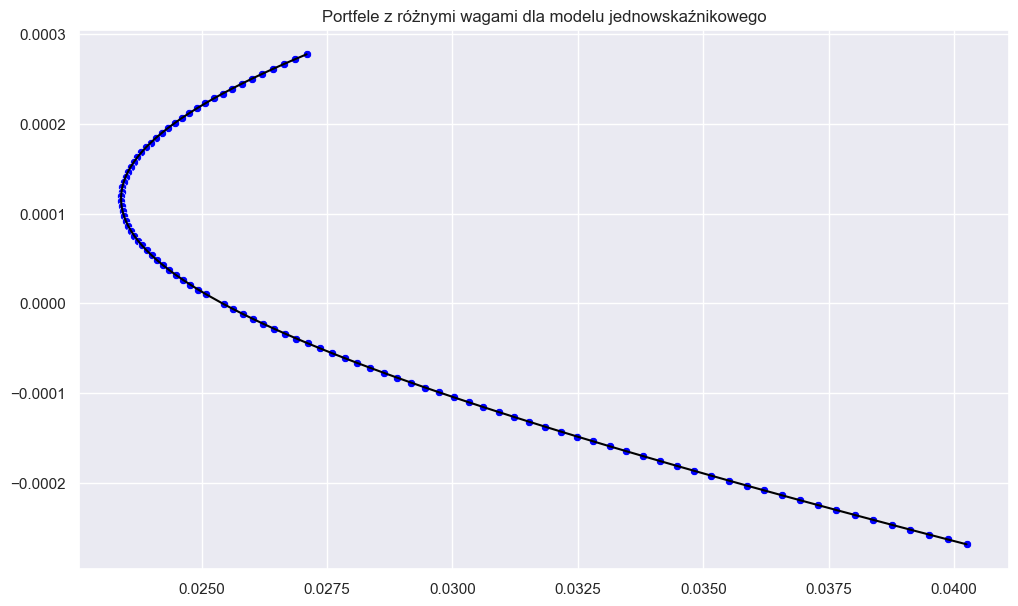

In [42]:
zwrot_residua = portfele_residua.iloc[2,:].values
ryzyko_residua = portfele_residua.iloc[3,:].values
sns.lineplot(x=ryzyko_residua, y=zwrot_residua, color = "black", sort=False)
sns.scatterplot(x=ryzyko_residua, y=zwrot_residua, color = "blue")
plt.title("Portfele z różnymi wagami dla modelu jednowskaźnikowego")

In [43]:
# koniec kodow Gosi

In [62]:
# szukam indeksu gdzie ryzyko jest najmniejsze
min_risk_idx = portfele_residua.iloc[3,:].values.argmin()
min_risk_idx

29

In [63]:
portfele_residua.iloc[3,:].values.min() # minimalne ryzyko, całkiem podobne do tego co wyszlo w 1 zadaniu

0.02339699107708403

In [98]:
# dla odsetku wagi ropy 0.71 0 wagi gazu 0.29 ryzyko jest najmnijesze, w zadaniu pierwszym
# u Adriana wyszło całkiem podobnie
min_risk = portfele_residua.iloc[:, min_risk_idx]
min_risk

waga gaz       0.2900
waga ropa      0.7100
stopa zwrotu   0.0001
ryzyko         0.0234
Name: skóra: 0.29\nguma: 0.71, dtype: float64

In [94]:
x = portfele_residua.iloc[1, min_risk_idx] # x - odsetek ropy
print("Odetek ropy",np.round((1 - x), 3)) 
print("Stosunek ropy do gazu 1:",np.round((1 - x)/x, 3), 
      "\nryzyko wynosi: ", np.round(portfele_residua.iloc[3, min_risk_idx], 4))

Odetek ropy 0.29
Stosunek ropy do gazu 1: 0.408 
ryzyko wynosi:  0.0234


Text(0.5, 1.0, 'Portfele z różnymi wagami dla modelu jednowskaźnikowego')

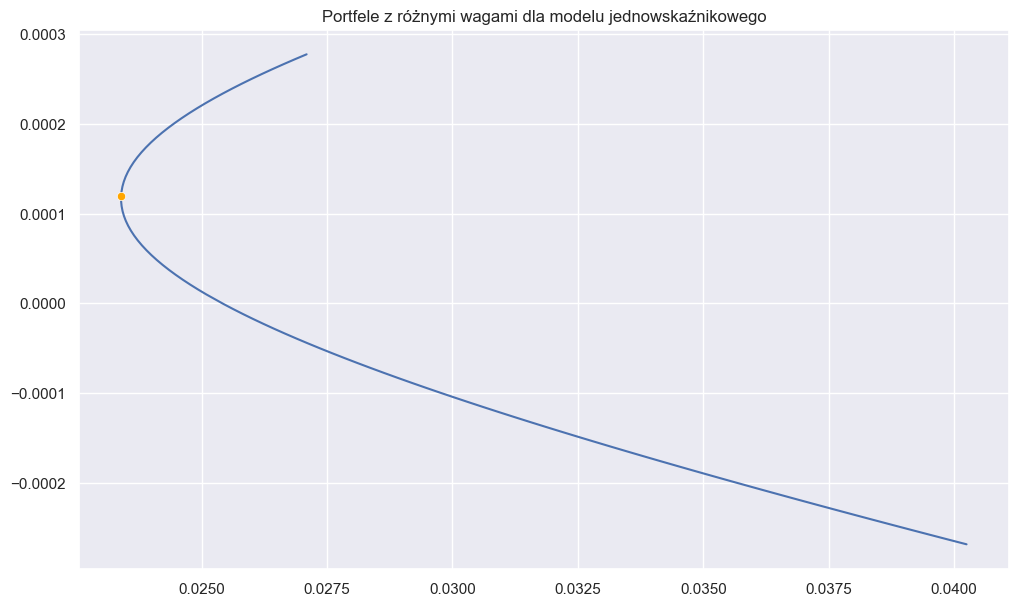

In [119]:
zwrot_residua = portfele_residua.iloc[2,:].values
ryzyko_residua = portfele_residua.iloc[3,:].values
odsetek_ropy = portfele_residua.iloc[1, :].values
sns.lineplot(x=ryzyko_residua, y=zwrot_residua, sort=False)
sns.scatterplot(x=[min_risk[3]], y=[min_risk[2]], color = "orange", zorder=2)
plt.title("Portfele z różnymi wagami dla modelu jednowskaźnikowego")

Text(0.5, 0, 'Odsetek ropy w portfelu')

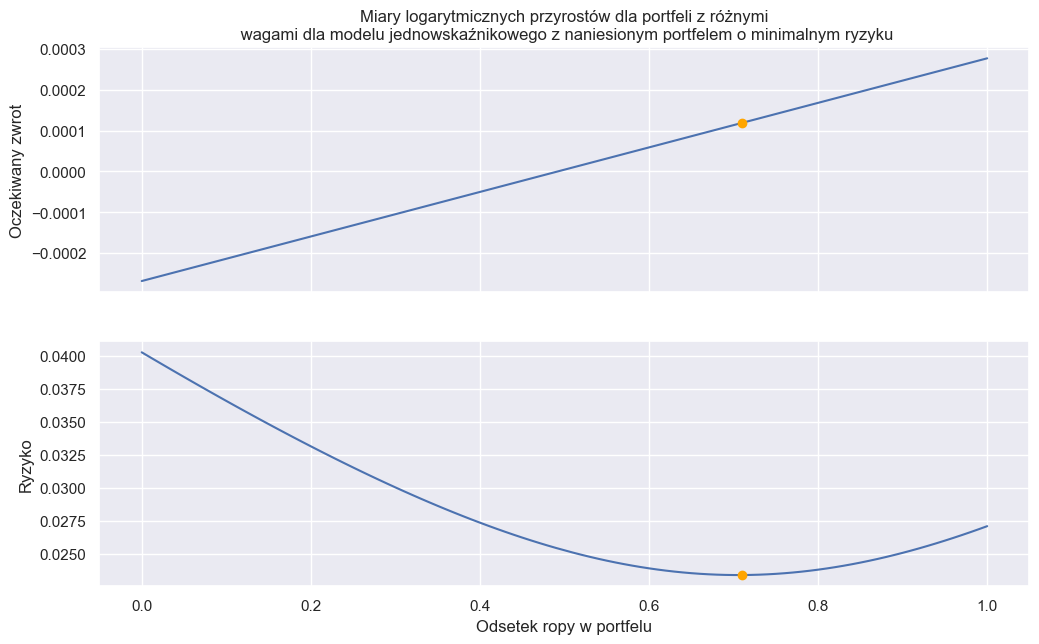

In [125]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(odsetek_ropy, zwrot_residua, zorder=1)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli z różnymi\n'
                 ' wagami dla modelu jednowskaźnikowego z naniesionym portfelem o minimalnym ryzyku')
axs[0].scatter(x=[min_risk[1]], y=[min_risk[2]], color="orange", zorder=2)
axs[1].plot(odsetek_ropy, ryzyko_residua, zorder=1)
axs[1].scatter(x=[min_risk[1]], y=[min_risk[3]], c="orange", alpha=1, zorder=2)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')